# Import model and dataset

In [1]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import Flowers102
from torchvision.transforms import transforms
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models


import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
import copy
import time

import torch.nn as nn
import torch.optim as optim

In [2]:
# set to GPU if its available

device = torch.device('cpu')
if torch.cuda.is_available():
    print(f'Found {torch.cuda.device_count()} GPUs.')
    device = torch.device('cuda:0')
print(f'The device is set to {device}')


Found 1 GPUs.
The device is set to cuda:0


# Load model and image dataset

In [3]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [4]:
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize]),

    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])
}

training_set = datasets.ImageFolder('data2/train', transform=data_transforms['train'])
validation_set = datasets.ImageFolder('data2/valid', transform=data_transforms['validation'])

print(np.max(training_set.targets))
idx_to_class = { v:k for k,v in training_set.class_to_idx.items()}
# Pytorch's Image folder creates an internal representation of folder names to actual numbered labels 
# So we have to create another map to convert Pytorch label's to folder names and then convert those to actual flower names
print(idx_to_class)



# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=8, shuffle=False, num_workers=0)

dataloaders = {'train': training_loader, 'val': validation_loader}
dataset_sizes = {'train': len(training_set), 'val': len(validation_set)}

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

101
{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 

### Sanity Check (Display images)

tensor([70, 40, 58, 89, 18, 80, 33, 43])
tree poppy  sword lily  tiger lily  cyclamen  fritillary  bird of paradise  cape flower  wallflower


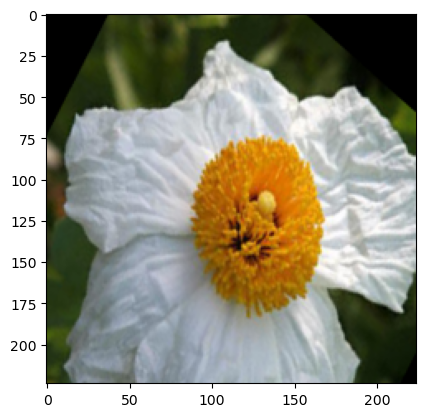

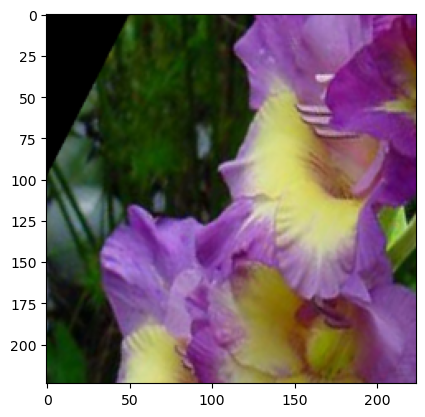

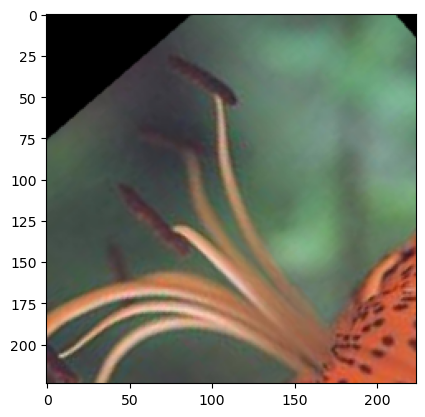

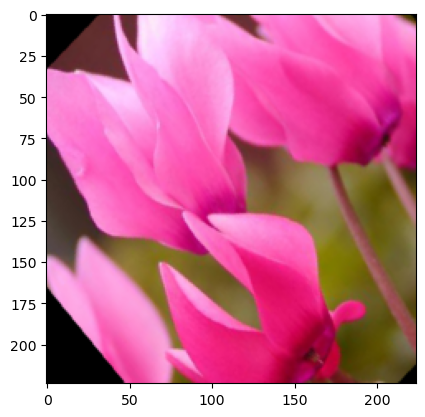

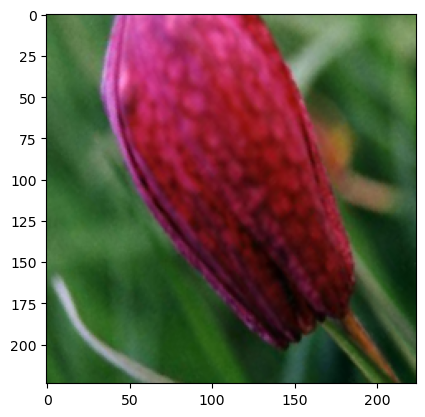

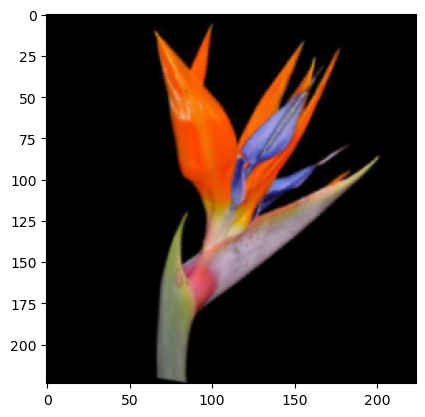

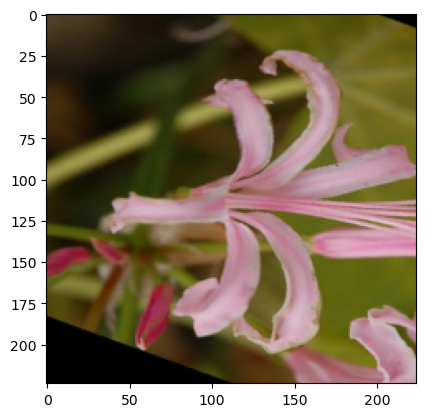

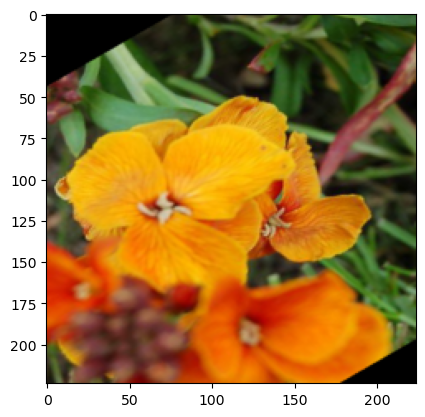

In [5]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.permute(1, 2, 0)
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image.numpy() + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# from https://github.com/bdevnani3/oxfordflowers102-label-name-mapping/blob/main/mapping.json
with open('udacity_label_to_name.json', 'r') as f:
    flower_to_name = json.load(f)

dataiter = iter(training_loader)
images, labels = next(dataiter)
print(labels[0:8])

# Create a grid from the images and show them
for image in images:
    imshow(image)
print('  '.join(flower_to_name[idx_to_class[labels[j].item()]] for j in range(8)))

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    model.to(device)
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {flower_to_name[idx_to_class[preds[j].item()]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(flower_to_name))

model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [9]:
# train model using transfer learning
model_tl = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=12)

Epoch 0/11
----------
train Loss: 3.5229 Acc: 0.2520
val Loss: 1.2862 Acc: 0.7225

Epoch 1/11
----------
train Loss: 1.3284 Acc: 0.6883
val Loss: 0.3748 Acc: 0.8973

Epoch 2/11
----------
train Loss: 0.7275 Acc: 0.8242
val Loss: 0.1719 Acc: 0.9572

Epoch 3/11
----------
train Loss: 0.5421 Acc: 0.8759
val Loss: 0.1512 Acc: 0.9621

Epoch 4/11
----------
train Loss: 0.4969 Acc: 0.8835
val Loss: 0.1543 Acc: 0.9621

Epoch 5/11
----------
train Loss: 0.4716 Acc: 0.8930
val Loss: 0.1398 Acc: 0.9670

Epoch 6/11
----------
train Loss: 0.4759 Acc: 0.8895
val Loss: 0.1425 Acc: 0.9707

Epoch 7/11
----------
train Loss: 0.4902 Acc: 0.8878
val Loss: 0.1312 Acc: 0.9670

Epoch 8/11
----------
train Loss: 0.4623 Acc: 0.8897
val Loss: 0.1262 Acc: 0.9694

Epoch 9/11
----------
train Loss: 0.4860 Acc: 0.8857
val Loss: 0.1347 Acc: 0.9658

Epoch 10/11
----------
train Loss: 0.4587 Acc: 0.8959
val Loss: 0.1265 Acc: 0.9694

Epoch 11/11
----------
train Loss: 0.4662 Acc: 0.8900
val Loss: 0.1253 Acc: 0.9707

Tr

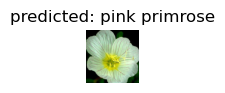

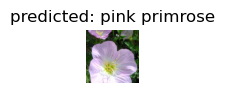

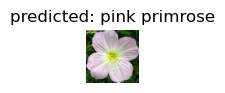

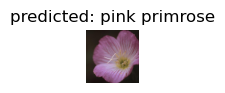

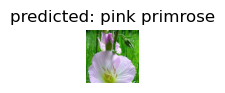

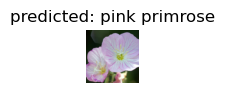

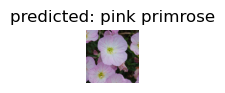

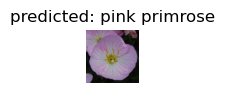

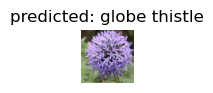

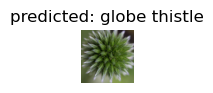

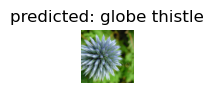

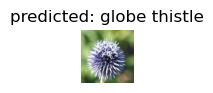

In [18]:
visualize_model(model_tl, num_images=12)

### Saving and Reloading the model

In [20]:
model_tl.cpu()
torch.save({'arch': 'resNet50',
            'state_dict': model_tl.state_dict(), 
            'class_to_idx': training_set.class_to_idx}, 
            'resNet50classifier.pth')

In [21]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['arch'] == 'resNet50':
        model = models.resnet50(weights=ResNet50_Weights)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized")
        exit()
    
    model.class_to_idx = chpt['class_to_idx']
    num_ftrs = model.fc.in_features

    model.fc = nn.Linear(num_ftrs, len(flower_to_name))

    model.load_state_dict(chpt['state_dict'])
    model.to(device) 
    return model

In [22]:
model_tl = load_model('resNet50classifier.pth')

/home/mchen/miniconda3/envs/ml_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
